## Augmentation, Morphology and Restoration

In [1]:
import cv2
import numpy as np
from skimage import morphology
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.restoration import inpaint
from skimage.transform import resize, warp, matrix_transform, AffineTransform
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
image = imread('image.jpg')
img_array = np.array(image)
print(img_array.shape)

(913, 688, 3)


In [3]:
# Rotation

def rotate_image(cx, cy, theta):

    theta = np.deg2rad(theta)
    
    trans_mat = np.array([
        [1, 0, -cx],
        [0, 1, -cy],
        [0, 0, 1]
    ])
                          
    trans_back = np.array([
        [1, 0, cx],
        [0, 1, cy],
        [0, 0, 1]
    ])
    
    rot_mat = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
        ])
    
    M = trans_back@rot_mat@trans_mat
                        
    return M

# Reflection

def reflect_image(cx, cy, axis):

    trans_mat = np.array([
        [1, 0, -cx],
        [0, 1, -cy],
        [0, 0, 1]
    ])

    trans_back = np.array([
        [1, 0, cx],
        [0, 1, cy],
        [0, 0, 1]
    ])

    if axis == 'x':
        reflect_mat = np.array([
            [1, 0, 0],
            [0, -1, 0],
            [0, 0, 1]
        ])
    elif axis == 'y':
        reflect_mat = np.array([
            [-1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("Axis must be 'x' or 'y'")
    
    M = trans_back@reflect_mat@trans_mat

    return M

(np.float64(-0.5), np.float64(687.5), np.float64(912.5), np.float64(-0.5))

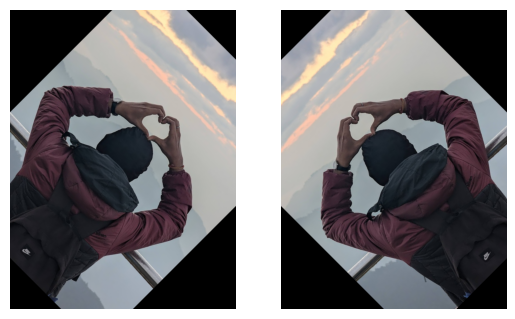

In [4]:
# Get center of image
cy, cx = image.shape[0] / 2, image.shape[1] / 2

# Get transformation matrix
M = rotate_image(cx, cy, theta=45)
N = rotate_image(cx, cy, theta=-45)

# Wrap matrix into AffineTransform
tf = AffineTransform(matrix=M)
tf1 = AffineTransform(matrix=N)

# Apply warp
rotated = warp(image, inverse_map=tf.inverse)
rotated1 = warp(image, inverse_map=tf1.inverse)

# Show result
plt.subplot(1, 2, 1)
plt.imshow(rotated)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(rotated1)
plt.axis('off')

(np.float64(-0.5), np.float64(687.5), np.float64(912.5), np.float64(-0.5))

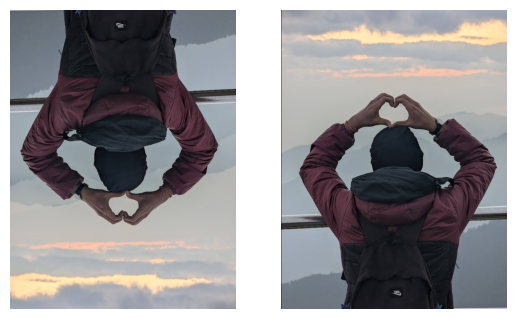

In [5]:
# Get center of image
cy, cx = image.shape[0] / 2, image.shape[1] / 2

# Get transformation matrix
M = reflect_image(cx, cy, axis = 'x')
N = reflect_image(cx, cy, axis = 'y')

# Wrap matrix into AffineTransform
tf = AffineTransform(matrix=M)
tf1 = AffineTransform(matrix=N)

# Apply warp
reflected = warp(image, inverse_map=tf.inverse)
reflected1 = warp(image, inverse_map=tf1.inverse)

# Show result
plt.subplot(1, 2, 1)
plt.imshow(reflected)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reflected1)
plt.axis('off')

In [6]:
# Shearing

def shearing_image (cx, cy, Shx = 0.0, Shy = 0.0):

    shear = np.array([
        [1, Shx, 0],
        [Shy, 1, 0],
        [0, 0, 1]
    ])
    
    return shear

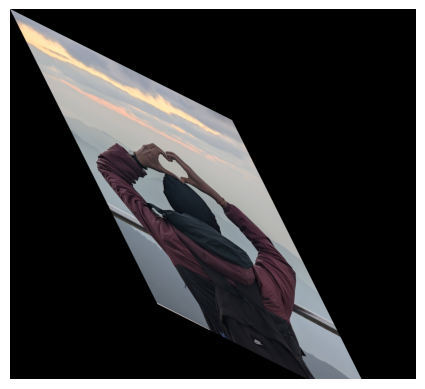

In [7]:
# Get center
cy, cx = image.shape[0] / 2, image.shape[1] / 2

# Get shearing matrix
M = shearing_image(cx, cy, Shx=0.5, Shy=0.5)

# Wrap into AffineTransform
tf = AffineTransform(matrix=M)

# Compute bounding box for new image size
h, w = image.shape[:-1]
corners = np.array([
    [0, 0],
    [w, 0],
    [0, h],
    [w, h]
])
transformed_corners = matrix_transform(corners, tf)
minc = transformed_corners.min(axis=0)
maxc = transformed_corners.max(axis=0)

# Compute output shape and offset
output_shape = np.ceil(maxc - minc).astype(int)
offset = AffineTransform(translation=-minc)
combined = tf + offset  # chain transforms

# Apply warp
sheared = warp(image, inverse_map=combined.inverse, output_shape=output_shape)

# Plot
plt.imshow(sheared)
plt.axis('off')
plt.show()

In [8]:
# Scaling

def scaling_image (cx, cy, Sx = 0.0, Sy = 0.0):

    trans_mat = np.array([
        [1, 0, -cx],
        [0, 1, -cy],
        [0, 0, 1]
    ])
    scale = np.array([
        [Sx, 0, 0],
        [0, Sy, 0],
        [0, 0, 1]
    ])
    trans_back = np.array([
        [1, 0, cx],
        [0, 1, cy],
        [0, 0, 1]
    ])
    
    return trans_back@ scale@trans_mat

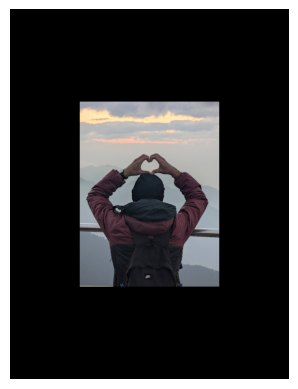

In [9]:
# Get center
cy, cx = image.shape[0]/2, image.shape[1]/2

# Passing into fn
M = scaling_image(cx, cy, Sx = 1/2, Sy = 1/2)

#Wrap matrix into AffineTransform
tf = AffineTransform(matrix=M)
scaled = warp(image, inverse_map = tf.inverse)

#Plot
plt.imshow(scaled)
plt.axis('off')
plt.show()

(np.float64(-0.5), np.float64(1375.5), np.float64(1825.5), np.float64(-0.5))

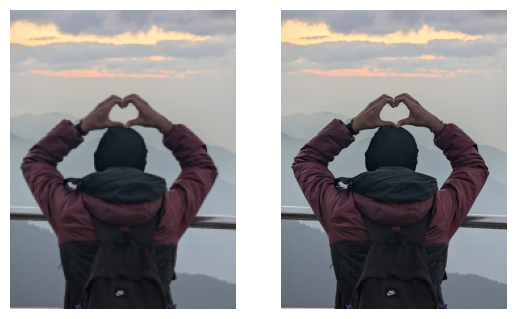

In [10]:
#Resize

downsample = resize(image, (image.shape[0]//4, image.shape[1]//4), anti_aliasing = True, order = 5) #4-5 provides us the Non-Linear Polynomial Spline Interpolation
upsample = resize(image, (image.shape[0]*2, image.shape[1]*2), anti_aliasing = True, order = 5) #4-5 provides us the Non-Linear Polynomial Spline Interpolation

plt.subplot(1, 2, 1)
plt.imshow(downsample)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(upsample)
plt.axis('off')

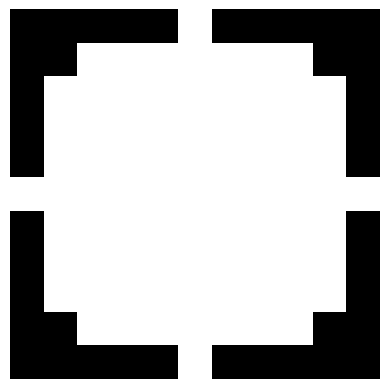

In [11]:
#Morphological Operation
shape_disk = morphology.disk(5)

plt.axis('off')
plt.imshow(shape_disk, cmap = 'gray')


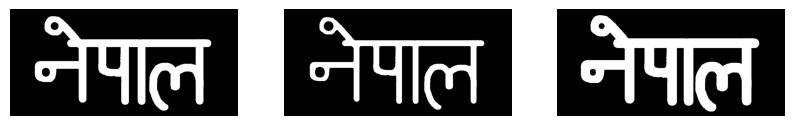

In [25]:
image_morph = imread('image_morph.png')
image_morph = image_morph[:, :, :3]

gray = rgb2gray(image_morph)
thresh = threshold_otsu(gray)
binary = gray > thresh
erosion = morphology.binary_erosion(binary, footprint=shape_disk)
dilation = morphology.binary_dilation(binary, footprint=shape_disk)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(image_morph, cmap ='gray')

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(erosion, cmap = 'gray')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(dilation, cmap = 'gray')

(913, 688)


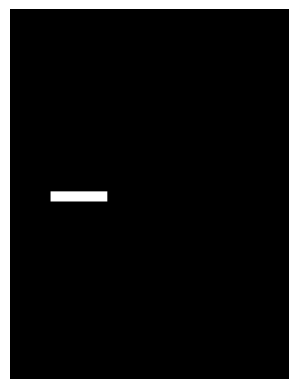

In [13]:
#Image Restoration
##Masking First
mask = np.zeros(image.shape[:-1], dtype=np.uint8)
mask[450:475, 100:240] = 1
print(mask.shape)

plt.axis('off')
plt.imshow(mask, cmap='gray')

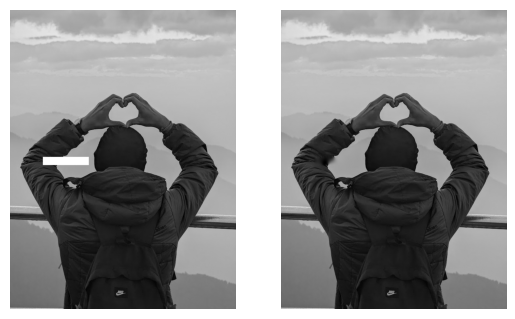

In [28]:
##Using Biharmonic Mehod
damaged_image = image.copy()

damaged_image_gray = rgb2gray(damaged_image)
damaged_image_gray[mask == 1] = 1

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(damaged_image_gray, cmap = 'gray')

restored_biharmonic = inpaint.inpaint_biharmonic(damaged_image_gray, mask)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(restored_biharmonic, cmap='gray')


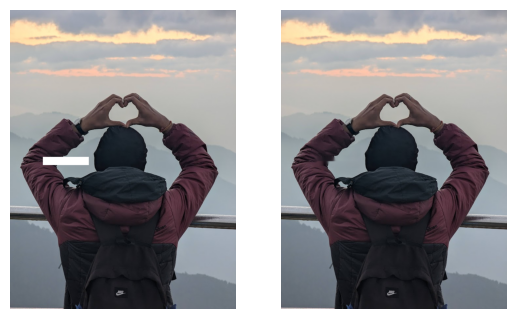

In [ ]:
##Using Fast Marching Method 

image = cv2.imread('image.jpg')
damaged_image = imread('image.jpg')

mask = np.zeros(image.shape[:-1], dtype=np.uint8)
mask[450:475, 100:240] = 1                                 

damaged_image[mask == 1] = 255

plt.subplot(1,2,1)
plt.imshow(damaged_image)
plt.axis('off')

inpainted = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
inpaint_real = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(inpaint_real)


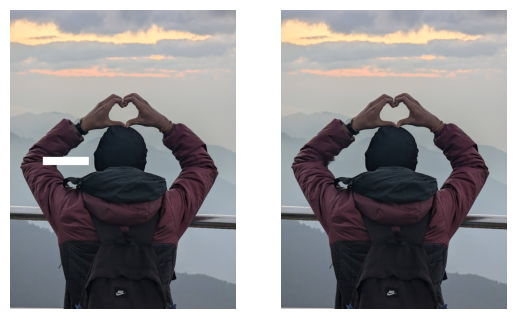

In [31]:
##Using Naiver Spikes Filling

image = cv2.imread('image.jpg')
damaged_image = imread('image.jpg')

mask = np.zeros(image.shape[:-1], dtype=np.uint8)
mask[450:475, 100:240] = 1   
                               
damaged_image[mask == 1] = 255

plt.subplot(1,2,1)
plt.imshow(damaged_image)
plt.axis('off')

inpainted = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)
inpaint_real = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(inpaint_real)
